In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data in a list.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

In [4]:
def plot_2d_characters(C: torch.tensor, size: int = 8) -> None:
    """
    Given a look-up table C of 2D character representations plot them on the grid.
    Args:
        C(torch.tensor, shape=[num_characters, 2]): Look-up table.
        size(int)                                 : Size of the plot.
    """
    vowels = ['a', 'e', 'i', 'o', 'u']  # list of all vowels in alphabet
    colors = ['red' if itos[ch] in vowels else 'blue' for ch in range(C.shape[0])]  # color vowels red
    colors[stoi['.']] = 'green'  # color '.' token green

    plt.figure(figsize=(size, size))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c=colors)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [5]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X).cuda(), torch.tensor(Y).cuda()
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

---

In [6]:
# Model's hyperparameters
chs_amt = len(stoi)             # characters amount (27)
repr_dim = 9                    # characters representation deimensions 
cnx_size = 4                    # contex_size / characters considered for prediction 
ipt_size = repr_dim * cnx_size  # input size of a single example
W1_ns = 250                     # Amount of neurons in the first layer

In [7]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# Split data in Build, Development and Test sets.
Xtr, Ytr = build_dataset(words[:n1], cnx_size, True)
Xdev, Ydev = build_dataset(words[n1:n2], cnx_size, True)
Xte, Yte = build_dataset(words[n2:], cnx_size, True)

Input: torch.Size([182597, 4]), Output: torch.Size([182597])
Input: torch.Size([22761, 4]), Output: torch.Size([22761])
Input: torch.Size([22788, 4]), Output: torch.Size([22788])


In [118]:
# Initialize model
g = torch.Generator().manual_seed(13)
C = torch.randn(size=[chs_amt, repr_dim], generator=g).cuda()
W1 = torch.randn([ipt_size, W1_ns], generator=g).cuda()
b1 = torch.randn([W1_ns], generator=g).cuda()
W2 = torch.randn([W1_ns, chs_amt], generator=g).cuda() 
b2 = torch.randn([chs_amt], generator=g).cuda()

parameters = [C, W1, b1, W2, b2]
tot_prms = sum(p.nelement() for p in parameters)  # total amount of parameters in a model
# Tell torch to compute gradients for created parameters.
for p in parameters:
    p.requires_grad = True
tot_prms

16270

In [119]:
"""Requires model and C-table initialization! Modifies global parameters!"""
def forward_pass(ipt_exmps: torch.tensor, tgt_exmps: torch.tensor) -> torch.tensor:
    """
    Given input parameters, input and target examples performs a forward pass and returns loss.
    Args:
        ipt_exmps(torch.tensor, shape=[m, ipt_size]): Input tensor, m - number of examples.
        tgt_exmps(torch.tensor, shape=[m])          : Target tensor, m - number of examples.
    Returns:
        loss(torch.tensor): evaluated loss.
    """
    emb = C[ipt_exmps]
    h = torch.tanh(emb.view(-1, ipt_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, tgt_exmps)
    return loss

In [120]:
# Place for tracking:
lri = []
lossi = []
stepi = []

usteps = []
trlosses = []
devlosses = []

In [121]:
# Learning hyperparameters
iters_num = 100000                  # number of iterations
lr = 0.3                     # learning rate
batch_size = 512               # size of the mini-batch
log_loss_step = False          # pring loss at each gradient step
upd_step = 3000
log_upd = True        

In [122]:
for i in range(iters_num):
    if (i+1) % upd_step == 0:
        lr *= 0.9
        batch_size = int(batch_size*1.02)
        trloss = forward_pass(Xtr, Ytr)
        devloss = forward_pass(Xdev, Ydev)
        trlosses.append(trloss)
        devlosses.append(devloss)
        usteps.append(i)
        if log_upd:
            print(f'{lr=:0.5f} | {batch_size=} | {trloss=:0.5f} | {devloss=:0.5f}')
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    """Forward pass"""
    loss = forward_pass(Xtr[ix], Ytr[ix])
    if log_loss_step:
        print(loss.item())
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)


lr=0.27000 | batch_size=522 | trloss=3.08631 | devloss=3.11364
lr=0.24300 | batch_size=532 | trloss=2.39586 | devloss=2.42938
lr=0.21870 | batch_size=542 | trloss=2.46882 | devloss=2.50497
lr=0.19683 | batch_size=552 | trloss=2.24777 | devloss=2.28878
lr=0.17715 | batch_size=563 | trloss=2.23349 | devloss=2.27236
lr=0.15943 | batch_size=574 | trloss=2.19982 | devloss=2.24441
lr=0.14349 | batch_size=585 | trloss=2.17843 | devloss=2.22242
lr=0.12914 | batch_size=596 | trloss=2.16974 | devloss=2.21495
lr=0.11623 | batch_size=607 | trloss=2.15649 | devloss=2.20550
lr=0.10460 | batch_size=619 | trloss=2.14968 | devloss=2.19834
lr=0.09414 | batch_size=631 | trloss=2.14224 | devloss=2.19078
lr=0.08473 | batch_size=643 | trloss=2.13622 | devloss=2.18687
lr=0.07626 | batch_size=655 | trloss=2.12775 | devloss=2.17918
lr=0.06863 | batch_size=668 | trloss=2.12596 | devloss=2.17691
lr=0.06177 | batch_size=681 | trloss=2.12126 | devloss=2.17242
lr=0.05559 | batch_size=694 | trloss=2.11859 | devloss=

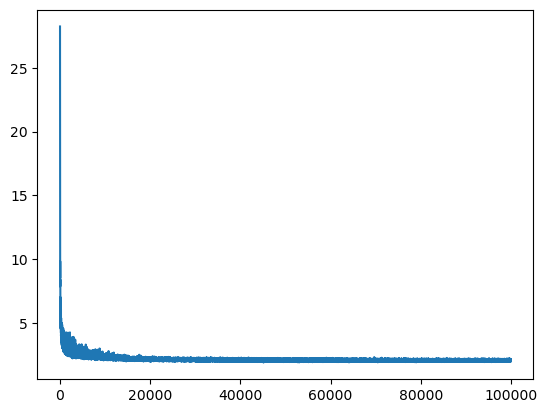

In [123]:
plt.plot(stepi, lossi)

In [124]:
train_loss = forward_pass(Xtr, Ytr)
dev_loss = forward_pass(Xdev, Ydev)
print(f"train: {train_loss}\ndevop: {dev_loss}")

train: 2.0984983444213867
devop: 2.1546566486358643


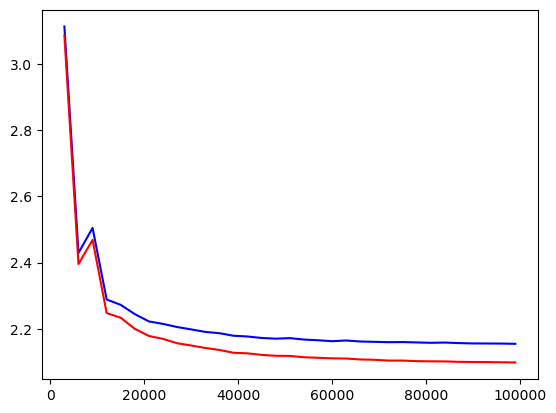

In [125]:
plt.plot(usteps, [loss.item() for loss in devlosses], c='blue')
plt.plot(usteps, [loss.item() for loss in trlosses], c='red')

In [ ]:
"""
batch_size - makes the line less thick. Gradient steps are more percise.
"""